### 1. imports

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

In [4]:
# CNN 
# net = 2d --> 1d
# 1d: (linr(선형변환) -> relu(비선형변환))
# 2d: (conv(선형번환) -> relu(비선형변환) -> mp(비선형변환)) 

`-` conv $\to$ conv $\to$ ... (비효율 하나로 퉁칠수 있는거 존재 : linr와 유사)

### 2. MNIST

In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False,transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False,transform=torchvision.transforms.ToTensor())
X,y = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=6000,shuffle=True)))
XX,yy = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=1000,shuffle=True)))

`-` pytorch는 자동으로 원핫인코딩 해줌..

In [7]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,32,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(32,32,kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    #---#
    torch.nn.Linear(3200,10)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(100):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

`-` **배치사이즈 만들어서 해보기**

In [8]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9798, device='cuda:0')

In [9]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.9590, device='cuda:0')

In [10]:
torch.cuda.empty_cache()

### 3. CIFAR10

In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False,transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=torchvision.transforms.ToTensor())
X,y = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=10000,shuffle=True)))
XX,yy = next(iter(torch.utils.data.DataLoader(train_dataset,batch_size=2000,shuffle=True)))

Files already downloaded and verified


In [4]:
X[0].shape

torch.Size([3, 32, 32])

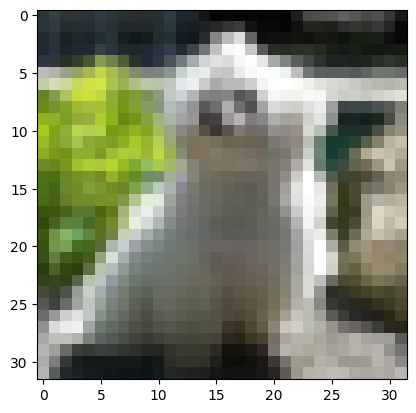

In [5]:
plt.imshow(torch.einsum('chw -> hwc', X[0]))

#### A. 직접설계

In [6]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,32,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(32,32,kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    #---#
    torch.nn.Linear(4608,10)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(500):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [7]:
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.6984, device='cuda:0')

In [8]:
(net(XX).argmax(axis=1) == yy).float().mean()

tensor(0.5910, device='cuda:0')

`-` 표현력 자체에 문제가 있어보임(언더피팅)

In [18]:
torch.cuda.empty_cache()

#### B. 알렉스넷

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

In [19]:
img = torch.zeros(1,3*224*224).reshape(1,3,224,224)
img.shape

torch.Size([1, 3, 224, 224])

In [20]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,96,kernel_size=(11,11),stride=4),
    torch.nn.ReLU(),    
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(96,256,kernel_size=(5,5),padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(256,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),    
    torch.nn.Conv2d(384,256,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),    
    torch.nn.MaxPool2d((3,3),stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(6400,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096,4096),        
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),    
    torch.nn.Linear(4096,1000),
)

#### C. 알렉스넷으로 ImageNet 적합

In [21]:
net[-1] = torch.nn.Linear(4096,10)

In [22]:
img = torch.randn(1,3,32,32)

`-` 실패... 이미지 사이즈가 맞지 않음

`-` 224, 224에서만 쓸 수 있음..

In [27]:
#net(img)

In [24]:
net[:5](img).shape

torch.Size([1, 256, 2, 2])

In [25]:
net[5]

MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)

#### D. renset18

In [31]:
net = torchvision.models.resnet18()
#net 

In [32]:
net.fc = torch.nn.Linear(512,10)

In [33]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(500):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [34]:
net.eval()
print((net(X).argmax(axis=1) == y).float().mean())
print((net(XX).argmax(axis=1) == yy).float().mean())

tensor(1., device='cuda:0')
tensor(0.6100, device='cuda:0')


`-` 오버피팅이 있어보이긴 하지만 표현력 자체는 올라감

In [35]:
torch.cuda.empty_cache()

#### E. resnet18, pretrained = True

`-` 아이디어 : 하나를 잘하는 모델은 다른 것도 잘하지 않을까? -> transger learning

`-` 가중치까지 가져옴

In [37]:
net = torchvision.models.resnet18(pretrained=True) # 아키텍처 + 학습된 가중치까지 
net.fc = torch.nn.Linear(512,10)

/root/anaconda3/envs/pypy/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/envs/pypy/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [38]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
net.to("cuda:0")
X = X.to("cuda:0")
y = y.to("cuda:0")
XX = XX.to("cuda:0")
yy = yy.to("cuda:0")
#---#
for epoc in range(500):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [39]:
net.eval()
print((net(X).argmax(axis=1) == y).float().mean())
print((net(XX).argmax(axis=1) == yy).float().mean())

tensor(1., device='cuda:0')
tensor(0.7945, device='cuda:0')


`-` 잘함 (오버피팅은 여전히 있음)

In [40]:
torch.cuda.empty_cache()

### 4. XAI란?

<https://brunch.co.kr/@hvnpoet/140>